### This is notebook of development of a top tagger using scikit-learn and pandas

In [1]:
from common import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.covariance import EmpiricalCovariance

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

from baseTagger import *

%matplotlib inline

#### The get_csv() function to read data from csv file. The original csv file is produced from ROOT file using the [convert_ROOT_to_CSV.py](convert_ROOT_to_CSV.py) code. The data includes various kinematic variables from both the $t\bar{t}$ (ttbar) sample and $Z(\rightarrow\nu\nu$) (zinv) sample. The ttbar sample contains the top quark signal while the zinv sample contains pure background. We select three AK4 jets for a combination where we introduce the major kinematic variables in the top quark rest-frame.

In [2]:
def get_csv(orifilename, outfilename, forceRedo = False):
    if not os.path.isfile(outfilename) or forceRedo:
        if not os.path.isfile(orifilename):
            print('orifilename : {} does not exist!'.format(orifilename))
            sys.exit(1)        
        df_ori = pd.read_csv(orifilename, compression='gzip')
        df = df_ori[(df_ori['cand_dRMax']<1.5) & (df_ori['cand_m']>100) & (df_ori['cand_m']<250)]
        to_drop = [x for x in df_ori.columns if 'Unnamed' in x]
        df = df.drop(to_drop, axis=1)
        df.to_csv(outfilename)
    else:
        df = pd.read_csv(outfilename)
        to_drop = [x for x in df.columns if 'Unnamed' in x]
        df = df.drop(to_drop, axis=1)
    return df

#### The samples are split into two. One is used for training, the other is used for validation.

In [3]:
df = get_csv('training.csv', 'dRMax_LE_1p5_m_in_100_250_training.csv')

#### Plots of the major kinematic variables and their correlations
The 1D histograms clearly show the difference in shapes between sginal and background

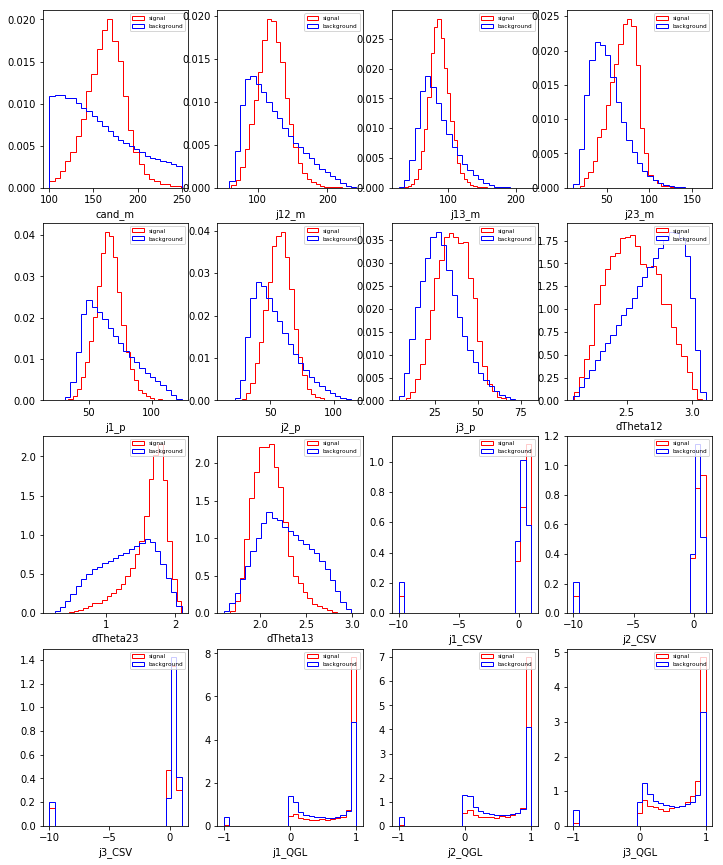

In [4]:
plt.rc('figure', figsize=(12, 15))
nfig_x = 4
nfig_y = 4
figs, axes = plt.subplots(nfig_y, nfig_x)
for iy in range(nfig_y):
    for ix in range(nfig_x):
        _=axes[iy, ix].hist(df[df['answer']==1].ix[:, ix+iy*nfig_x], bins=25, normed=True, color='red', histtype='step', label='signal')
        _=axes[iy, ix].hist(df[df['answer']==0].ix[:, ix+iy*nfig_x], bins=25, normed=True, color='blue', histtype='step', label='background')
        _=axes[iy, ix].set_xlabel(df.columns[ix+iy*nfig_x])
        _=axes[iy, ix].legend(loc='best', fontsize='xx-small')

The scatter plots are useful to see the correlations but in general the multivariate analysis can handle well the correlations 

In [5]:
from scipy.stats import gaussian_kde
from sklearn.neighbors.kde import KernelDensity
plt.rc('figure', figsize=(15, 15))

def plot_scatter(df_input, nVars, nBins):
    # See http://matplotlib.org/users/colormaps.html
    # also, http://matplotlib.org/api/pyplot_summary.html?highlight=colormaps#matplotlib.pyplot.colormaps
    cm = plt.cm.get_cmap('rainbow')
    figs, axes = plt.subplots(nVars, nVars)
#    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0, wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for iy in range(nVars):
        for ix in range(nVars):
            x_col = df_input.ix[:, ix]
            y_col = df_input.ix[:, iy]
            if ix != iy:
                xy_col = list(zip(x_col, y_col))
                bandwidth = max((np.amax(x_col)-np.amin(x_col))/nBins, (np.amax(y_col)-np.amin(y_col))/nBins)
                kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(xy_col)
                z = np.exp(kde.score_samples(xy_col)) 
                # See http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
                # s: marker size   lw: line width
                sc =axes[iy, ix].scatter(x_col, y_col, c=z, cmap=cm, marker='.', s=2, label='(%s, %s)'%(df.columns[ix], df.columns[iy]))
#                _=axes[iy, ix].legend(loc='best', fontsize='small')
#                _=figs.colorbar(sc, ax=axes[iy, ix])
            else:
                _=axes[iy, ix].hist(x_col, bins=nBins)
            # first make all axes invisible for all subplots
            _=axes[iy, ix].get_xaxis().set_visible(False)
            _=axes[iy, ix].get_yaxis().set_visible(False)            
            if ix ==0:
                _=axes[iy, ix].set_ylabel(df.columns[iy])
                _=axes[iy, ix].get_yaxis().set_visible(True)
            if iy == nVars-1:
                _=axes[iy, ix].set_xlabel(df.columns[ix])
                _=axes[iy, ix].get_xaxis().set_visible(True)
            if ix == nVars-1:
                _=axes[iy, ix].yaxis.set_label_position('right')
                _=axes[iy, ix].yaxis.tick_right()
                _=axes[iy, ix].set_ylabel(df.columns[iy])
                _=axes[iy, ix].get_yaxis().set_visible(True)
            if iy == 0:
                _=axes[iy, ix].xaxis.set_label_position('top')
                _=axes[iy, ix].xaxis.tick_top()
                _=axes[iy, ix].set_xlabel(df.columns[ix])
                _=axes[iy, ix].get_xaxis().set_visible(True)
#    figs.tight_layout()
    plt.show()

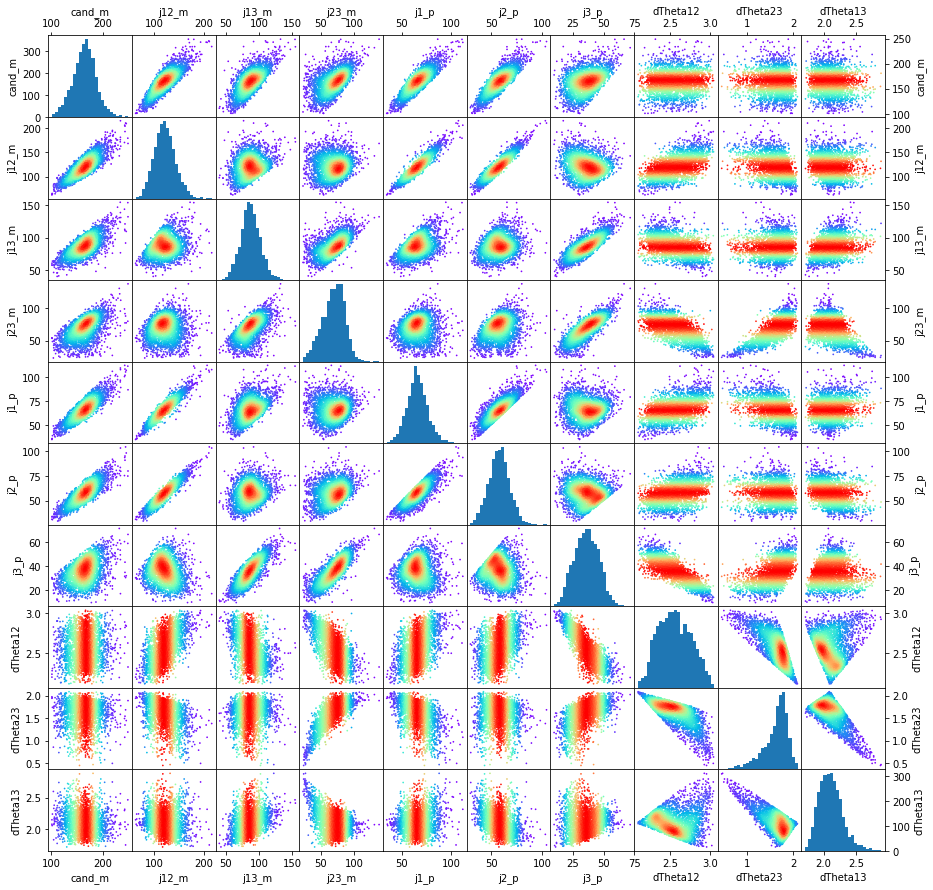

CPU times: user 1min 6s, sys: 378 ms, total: 1min 6s
Wall time: 1min 7s


In [6]:
#len_true_answer = len(df[df['answer']==1])
nSamples_for_scatterPlots = 3000
%time plot_scatter(df[df['answer']==1].sample(nSamples_for_scatterPlots), 10, 25)

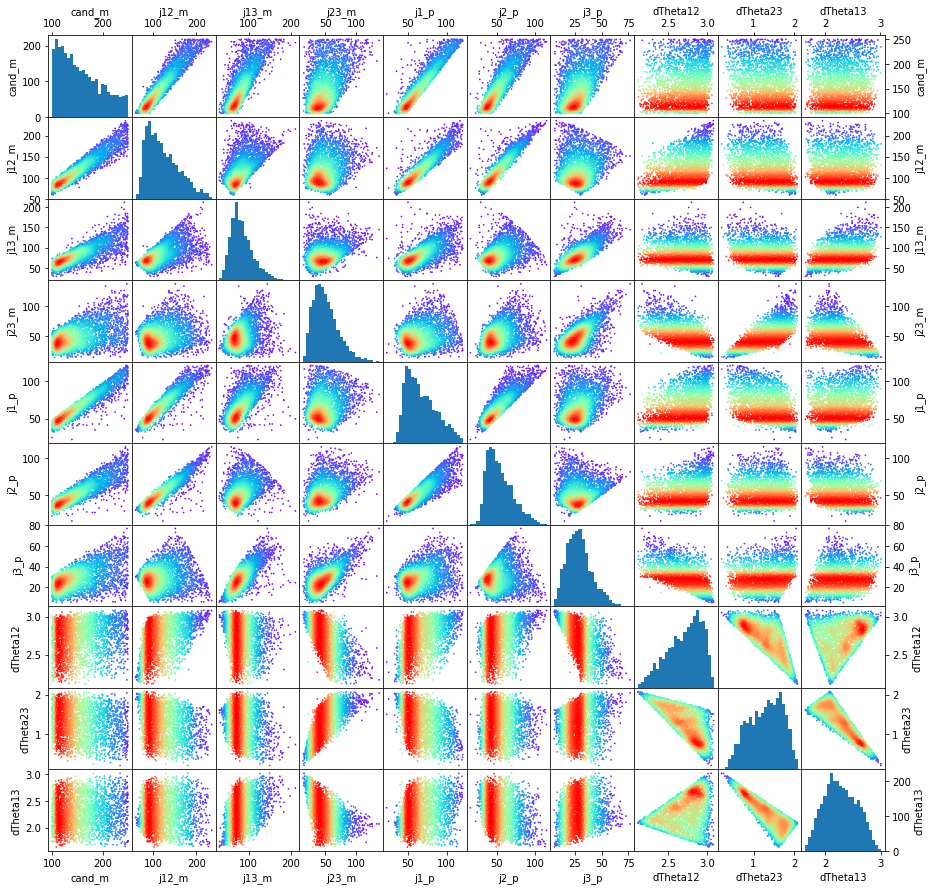

CPU times: user 1min 4s, sys: 353 ms, total: 1min 5s
Wall time: 1min 5s


In [7]:
#_=pd.scatter_matrix(df[df['answer']==0].ix[:, :'dTheta13'], diagonal='kde', c='k', alpha=0.3)
%time plot_scatter(df[df['answer']==0].sample(nSamples_for_scatterPlots), 10, 25)

#### Equalize the weighted number of events for signal and background

In [8]:
nSig_wt = df[df['answer']==1].weight.sum()
nBkg_wt = df[df['answer']==0].weight.sum()
weight = nSig_wt/nBkg_wt
df.loc[df['answer']==0, 'weight'] *= weight

#### Randomize the data before feeding into the classifier

In [9]:
df_shuffled = df.reindex(np.random.permutation(df.index))
npyInputData = np.array(df_shuffled.ix[:, :'j3_QGL'])
npyInputAnswer = np.array(df_shuffled.ix[:, 'answer'])
npyInputWgts = np.array(df_shuffled.ix[:, 'weight'])

#### Start the Random Forest classifier using scikit-learn package

In [10]:
#clf = RandomForestClassifier(n_estimators=100, max_depth=14, n_jobs=4)
clf = RandomForestClassifier(n_estimators=100, max_depth=18, n_jobs=4)
%time clf = clf.fit(npyInputData, npyInputAnswer, npyInputWgts)

CPU times: user 2min 46s, sys: 933 ms, total: 2min 47s
Wall time: 42.8 s


#### Save the trained results into pickle file (for future re-use)

In [11]:
fileObject = open("TrainingOutput.pkl",'wb')
out = pickle.dump(clf, fileObject)
fileObject.close()

#### Look at the feature importance of the input variables

In [12]:
listToGet = df_shuffled.columns[:df_shuffled.columns.get_loc('j3_QGL')+1]
feature_importance = clf.feature_importances_
feature_names = np.array(listToGet)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

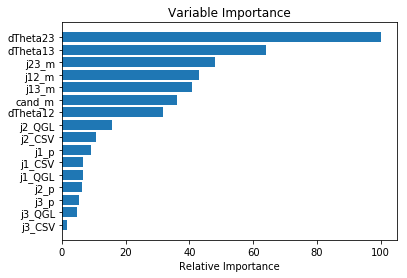

In [13]:
plt.rc('figure', figsize=(6, 4))
pos = np.arange(sorted_idx.shape[0]) + .5
_ = plt.barh(pos, feature_importance[sorted_idx], align='center')
_ = plt.yticks(pos, feature_names[sorted_idx])
_ = plt.xlabel('Relative Importance')
_ = plt.title('Variable Importance')

In [14]:
featureImportanceandNames = list(zip(feature_names, feature_importance))
print([featureImportanceandNames[a] for a in sorted_idx])

[('j3_CSV', 1.6530919459191817), ('j3_QGL', 4.6375341489673243), ('j3_p', 5.4637908878779458), ('j2_p', 6.3411456040633363), ('j1_QGL', 6.5509590670217772), ('j1_CSV', 6.7123086968325154), ('j1_p', 9.253427962822812), ('j2_CSV', 10.641085632207488), ('j2_QGL', 15.891136010575), ('dTheta12', 31.7319931015771), ('cand_m', 35.997449929934213), ('j13_m', 40.898354884683982), ('j12_m', 42.971553966647114), ('j23_m', 48.162977278279776), ('dTheta13', 63.955477082683686), ('dTheta23', 100.0)]


#### Now load in the validation sample

In [15]:
val_df = get_csv('validation.csv', 'dRMax_LE_1p5_m_in_100_250_validation.csv')
val_npInputList = np.array(val_df.ix[:, :'j3_QGL'])
val_npInputAnswers = np.array(val_df.ix[:, 'answer'])
val_npInputList_ttbar = np.array(val_df[val_df['procTypes']=='ttbar'].ix[:, :'j3_QGL'])
val_npInputAnswers_ttbar = np.array(val_df[val_df['procTypes']=='ttbar'].ix[:, 'answer'])
val_npInputList_zinv = np.array(val_df[val_df['procTypes']=='zinv'].ix[:, :'j3_QGL'])
val_npInputAnswers_zinv = np.array(val_df[val_df['procTypes']=='zinv'].ix[:, 'answer'])
val_slimNpData0_ttbar = val_npInputList_ttbar[val_npInputAnswers_ttbar==0]
val_slimNpData1_ttbar = val_npInputList_ttbar[val_npInputAnswers_ttbar==1]
val_slimNpData_zinv = val_npInputList_zinv[val_npInputAnswers_zinv==0]

#### The predict probability for the validation sample events

In [16]:
val_output = clf.predict_proba(val_npInputList)[:,1]
val_df['disc'] = val_output

In [17]:
from scipy.linalg import fractional_matrix_power
def diagElements(m):
    size = m.shape[0]
    return np.matrix(np.diag([m[i, i] for i in range(size)]))

def corrMat(m):
    sqrt_diag = fractional_matrix_power(diagElements(m), -0.5)
    return np.array(sqrt_diag * m  * sqrt_diag)

def plot_corrMat(corrMat_input, varNames, figs, ax):
    sc=ax.matshow(corrMat_input, cmap=plt.cm.seismic, vmin=-1, vmax=1)
    _=ax.set_xticks(range(len(varNames)))
    _=ax.set_xticklabels(varNames, rotation='vertical')
    _=ax.set_yticks(range(len(varNames))) 
    _=ax.set_yticklabels(varNames)
    _=figs.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

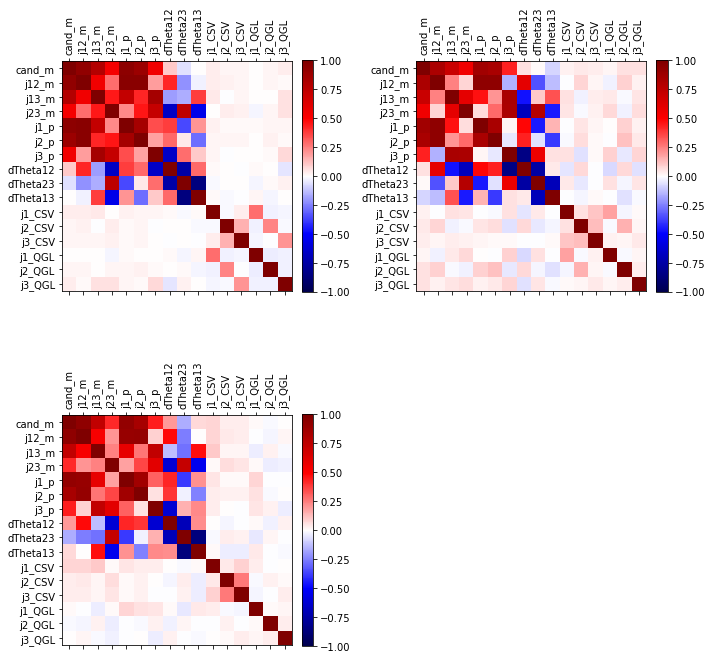

In [18]:
plt.rc('figure', figsize=(10, 10))
ecv = EmpiricalCovariance()
_=ecv.fit(val_slimNpData0_ttbar)
corr0_ttbar = corrMat(np.matrix(ecv.covariance_))
_=ecv.fit(val_slimNpData1_ttbar)
corr1_ttbar = corrMat(np.matrix(ecv.covariance_))
_=ecv.fit(val_slimNpData_zinv)
corr_zinv = corrMat(np.matrix(ecv.covariance_))
figs, axes = plt.subplots(2, 2)
plot_corrMat(corr0_ttbar, listToGet, figs, axes[0, 0])
plot_corrMat(corr1_ttbar, listToGet, figs, axes[0, 1])
plot_corrMat(corr_zinv, listToGet, figs, axes[1, 0])
figs.delaxes(axes[1, 1])
figs.tight_layout()
plt.show()

#### We have a base tagger used in the past. It's a simple tagger with squared cuts on some basic kinematic variables. Now we use it as a reference to find the improvement of the MVA training. Note that one of the feature the base tagger was it's high recall which is what we'd like to keep.

In [19]:
%time val_df['passBaseTagger'] = val_df.apply(baseTaggerReqs, axis=1)

CPU times: user 27 s, sys: 327 ms, total: 27.3 s
Wall time: 27.4 s


#### Some selections "sr_cuts" to ensure we have the events we are actually interested in. We then calculate various metrics for the base tagger.

In [20]:
sr_cuts = (val_df['Njet']>=4) & (val_df['MET']>200) & (val_df['cand_dRMax']<1.5)
baseTagger_fpr_tpr = val_df[sr_cuts].groupby(by=['answer', 'passBaseTagger'])['sampleWgt'].sum()
baseTagger_fpr_tpr
tp_base = baseTagger_fpr_tpr.loc[1, True]
fp_base = baseTagger_fpr_tpr.loc[0, True]
tn_base = baseTagger_fpr_tpr.loc[0, False]
fn_base = baseTagger_fpr_tpr.loc[1, False]
tpr_base = tp_base/(tp_base + fn_base)
fpr_base = fp_base/(fp_base + tn_base)

precision_base = tp_base/(tp_base + fp_base)
recall_base = tp_base/(tp_base + fn_base)

fscore_base = 2*precision_base*recall_base/(precision_base+recall_base)

fpr_base, tpr_base, precision_base, recall_base, fscore_base

answer  passBaseTagger
0       False              65868.476752
        True              128094.882087
1       False               3069.385830
        True               19059.424391
Name: sampleWgt, dtype: float64

(0.66040762984059254,
 0.86129458388375169,
 0.12951999059360264,
 0.86129458388375169,
 0.22517808937517617)

#### The roc plot and others for the trained results on the validation sample. We scan the fpr and tpr to find a cut on the output probablity value where we get same recall as the base tagger but reduced fpr. 

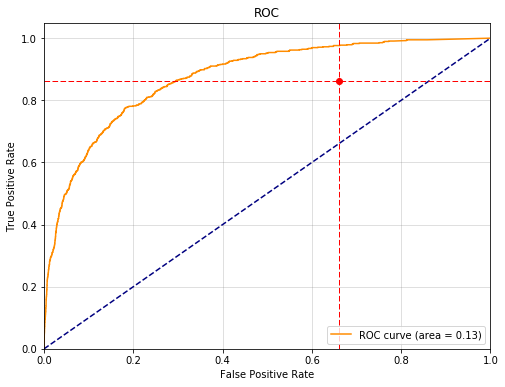

baseTagger tpr : 0.8612945838837517  fpr : 0.6604076298405925  fscore : 0.22517808937517617 --> precision : 0.12951999059360264  recall : 0.8612945838837517
mva (same_tpr) tpr : 0.8612945838837568  fpr : 0.29410507484697546  cut : 0.5361851198014679
mva (same_fpr) tpr : 0.9762219286657868  fpr : 0.6604548583757668  cut : 0.04888091394039877
mva (same_fscore) fscore : 0.22519509476031216  precision : 0.7214285714285714  recall : 0.1334214002642008  cut : 0.9959822499708824
mva (max_fscore) fscore : 0.44220430107526887  precision : 0.45006839945280436  recall : 0.4346103038309115  cut : 0.9797429081170107


In [21]:
plt.rc('figure', figsize=(8, 6))

val_npInputAnswers_sel = val_npInputAnswers[np.array(sr_cuts)]
val_output_sel = val_output[np.array(sr_cuts)]

precision, recall, thresholds_pr = precision_recall_curve(val_npInputAnswers_sel, val_output_sel)
fscore = 2*precision*recall/(precision + recall)
average_precision = average_precision_score(val_npInputAnswers_sel, val_output_sel)
fpr, tpr, thresholds_roc = roc_curve(val_npInputAnswers_sel, val_output_sel, sample_weight=np.array(val_df.loc[sr_cuts,'sampleWgt']))
roc_auc = auc(tpr, fpr)
_ = plt.plot(fpr, tpr, color = 'darkorange', label = 'ROC curve (area = %0.2f)'%roc_auc)
_ = plt.plot([0, 1], [0, 1], color='navy', linestyle = '--')
_ = plt.xlim([0.0, 1.0])
_ = plt.ylim([0.0, 1.05])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC')
_ = plt.legend(loc='lower right')
_ = plt.plot(fpr_base, tpr_base, 'or')
_ = plt.plot([0, 1], [tpr_base, tpr_base], ls='--', color='red', lw=1)
_ = plt.plot([fpr_base, fpr_base], [0, 1.05], ls='--', color='red', lw=1)
_ = plt.grid(b=True, color='grey', ls='-', lw=0.5, alpha=0.5)
plt.show()
#_=plt.plot(recall, precision, color = 'darkorange')
#_=plt.xlim([0.0, 1.0])
#_=plt.ylim([0.0, 1.05])
#_=plt.xlabel('recall')
#_=plt.ylabel('precision')
#_=plt.title('precision-recall')
#_=plt.plot(precision_base, recall_base, 'or')
#plt.show()
# Get the cut value for where we have same tpr as the tpr_base
idx_same_tpr = -1
idx_same_fpr = -1
for i in range(len(fpr)-1):
    if(tpr[i]<tpr_base and tpr[i+1]>=tpr_base):
        idx_same_tpr = i+1
    if(fpr[i]<fpr_base and fpr[i+1]>=fpr_base):
        idx_same_fpr = i+1
idx_same_fscore = -1
idx_max_fscore = -1
for i in range(len(fscore)-1):
    if(fscore[i]<fscore_base and fscore[i+1]>=fscore_base):
        idx_same_fscore = i+1
    if idx_max_fscore == -1 or (fscore[idx_max_fscore]<fscore[i]):
        idx_max_fscore = i
# We want a high recall (tpr) working point (as high as the base tagger)
mva_cut = thresholds_roc[idx_same_tpr]
alt_mva_cut = thresholds_roc[idx_same_fpr]
print('baseTagger tpr : {}  fpr : {}  fscore : {} --> precision : {}  recall : {}'.format(tpr_base, fpr_base, fscore_base, precision_base, recall_base))
print('mva (same_tpr) tpr : {}  fpr : {}  cut : {}'.format(tpr[idx_same_tpr], fpr[idx_same_tpr], mva_cut))
print('mva (same_fpr) tpr : {}  fpr : {}  cut : {}'.format(tpr[idx_same_fpr], fpr[idx_same_fpr], alt_mva_cut))
print('mva (same_fscore) fscore : {}  precision : {}  recall : {}  cut : {}'.format(fscore[idx_same_fscore], precision[idx_same_fscore], recall[idx_same_fscore], thresholds_pr[idx_same_fscore]))
print('mva (max_fscore) fscore : {}  precision : {}  recall : {}  cut : {}'.format(fscore[idx_max_fscore], precision[idx_max_fscore], recall[idx_max_fscore], thresholds_pr[idx_max_fscore]))

#### The probability output distribution for signal and background (selected cut value is indicated)

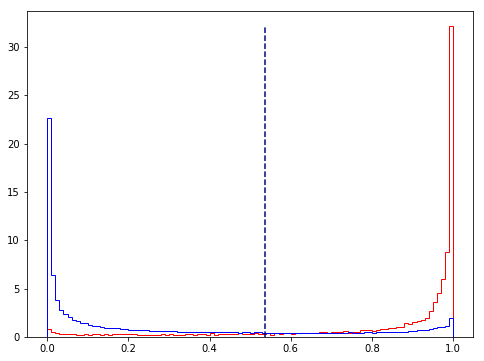

In [22]:
sig_val_output = val_output[val_npInputAnswers==1]
bkg_val_output = val_output[val_npInputAnswers==0]
y_sig, x_sig, _=plt.hist(sig_val_output, range = (0, 1.0), normed = True, color = 'red', bins = 100, histtype='step')
y_bkg, x_bkg, _=plt.hist(bkg_val_output, range = (0, 1.0), normed = True, color = 'blue', bins = 100, histtype='step')
_=plt.plot([mva_cut, mva_cut], [0, max(y_sig.max(), y_bkg.max())], color='navy', linestyle = '--')

#### Finally we apply both base tagger and the MVA tagger on all the validation events. However additional treatment is done to resolve the overlap where multiple tagged candiates might share the same AK4 jet(s).

In [ ]:
grouped_val_df = val_df.groupby(['evtNum', 'procTypes'])

In [ ]:
%time sr_grouped_baseTagger = grouped_val_df.apply(resolveOverlapHEP)
df_grouped_baseTagger = sr_grouped_baseTagger.reset_index()
df_grouped_baseTagger =df_grouped_baseTagger.rename(columns={0:'baseTagger'})
val_df_baseTagger = pd.merge(val_df, df_grouped_baseTagger, how='outer', left_on = ['evtNum', 'procTypes'], 
         right_on = ['evtNum', 'procTypes'])
val_df_baseTagger.index = val_df.index
%time sr_grouped_mvaTagger = grouped_val_df.apply(resolveOverlap, mva_cut)
df_grouped_mvaTagger = sr_grouped_mvaTagger.reset_index()
df_grouped_mvaTagger = df_grouped_mvaTagger.rename(columns={0:'mvaTagger'})
val_df_taggers = pd.merge(val_df_baseTagger, df_grouped_mvaTagger, 
                                          how='outer', left_on=['evtNum', 'procTypes'],
                                         right_on=['evtNum', 'procTypes'])
val_df_taggers.index = val_df.index

CPU times: user 1min 29s, sys: 316 ms, total: 1min 29s
Wall time: 1min 30s


#### An example display of the final DataFrame with the taggers

In [ ]:
val_df_taggers.head()

In [ ]:
!jupyter nbconvert --to python top_tagger.ipynb